- 시작 하기 전에

처음부터 전부 작동시키면 하루정도 걸려야 다 돌아가니 가급적 제가드린 데이터파일(중간 세이브 파일 개념)을 사용해주세요.

밑바닥부터 다 돌려보고 싶다면 dataguide에서 데이터 받아서 돌리시면 됩니다만 권장하진 않습니다.

In [31]:
import pandas as pd
import glob
from tqdm import tqdm
import os
import warnings
import gc
import numpy as np
import itertools
from tqdm import tqdm
import hotshot as hs
# import networkx as nx  # networkx 임포트
# from causalnex.structure.notears import from_pandas
# from causalnex.network import BayesianNetwork
# from econml.dr import DRLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import zscore
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import Loss
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import tensorflow as tf
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from itertools import product
import warnings

warnings.filterwarnings('ignore')

# 팩터 전략별로 필요한 데이터를 계산하여 monthly_merged_df에 추가합니다.

if 'monthly_merged_df' not in globals():
    monthly_merged_df = pd.read_csv(
        'data/merged_df_monthly_preprocessing.csv',
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
    )

pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

# CSV 부르기 및 기본적인 전처리 : 돌릴 필요 없음.

In [32]:
# DataFrame을 저장할 리스트 생성
df_list = []

# 1. 'data' 폴더 내에 'KSIF'가 포함된 CSV 파일 목록 가져오기
file_list = glob.glob('data/*KSIF*.csv')

# 파일이 존재하는지 확인
if not file_list:
    print("패턴에 맞는 파일을 찾을 수 없습니다.")
elif os.path.exists('data/merged_df_monthly.csv'):
    print("이미 통합한 월별 데이터 파일이 존재합니다. 해당 CSV를 불러옵니다.")
    merged_df_backup = pd.read_csv(
        'data/merged_df_monthly.csv',
        header=[0, 1, 2, 3],
        index_col=0,  # 첫 번째 열을 인덱스로 사용
        parse_dates=True  # 인덱스를 datetime으로 파싱
    )
    print("월별 CSV를 불러왔습니다.")
elif os.path.exists('data/merged_data.csv'):
    print("이미 통합한 일별 데이터 파일이 존재합니다. 해당 CSV를 월별로 전환합니다.")
    merged_df_backup = pd.read_csv(
        'data/merged_data.csv',
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
    )
    # 인덱스를 datetime으로 변환
    merged_df_backup.index = pd.to_datetime(merged_df_backup.index, errors='coerce')
    
    # 월별 리샘플링
    merged_df_backup = merged_df_backup.resample('M').last()
    
    # 월별 데이터 저장
    merged_df_backup.to_csv('data/merged_df_monthly.csv', encoding='utf-8-sig')
    
    print("월별 리샘플링된 데이터가 'merged_df_monthly.csv'로 저장되었습니다.")
    print("월별 CSV를 불러왔습니다.")
else:
    # tqdm을 사용하여 진행 상황 표시
    for file_path in tqdm(file_list, desc="파일 처리 중"):
        # 각 CSV 파일 읽기 (적절한 인코딩과 인덱스 설정)
        try:
            df = pd.read_csv(
                file_path,
                skiprows=8,
                header=[0, 1, 2, 3, 4, 5],
                index_col=0,  # 첫 번째 열을 인덱스로 사용
                encoding='cp949',
                parse_dates=True
            )
        except UnicodeDecodeError:
            # 'cp949' 인코딩이 안 될 경우 'euc-kr'로 시도
            df = pd.read_csv(
                file_path,
                skiprows=8,
                header=[0, 1, 2, 3, 4, 5],
                index_col=0,
                encoding='euc-kr',
                parse_dates=True
            )
        except Exception as e:
            print(f"파일 {file_path}를 로드하는 중 에러 발생: {e}")
            continue  # 에러 발생 시 다음 파일로 넘어감
        
        # 멀티인덱스 컬럼에 이름 지정
        df.columns.names = ['Symbol', 'Symbol Name', 'Kind', 'item', 'item Name', 'Frequency']
        
        # 인덱스 이름 지정 ('Date'로 설정)
        df.index.name = 'Date'
        
        # 인덱스를 datetime으로 변환
        df.index = pd.to_datetime(df.index, errors='coerce')
        
        # 'Kind', 'Frequency' 레벨 제거하여 필요한 컬럼만 남김
        df.columns = df.columns.droplevel(['Kind', 'Frequency'])
        
        # 리스트에 DataFrame 추가
        df_list.append(df)
    
    # 2. 모든 DataFrame을 수평적으로 병합
    print("DataFrame 병합 중...")
    merged_df_backup = pd.concat(df_list, axis=1)
    df_list  # 리스트 메모리에서 삭제
    gc.collect()  # 가비지 컬렉션 실행
    
    # 월별 리샘플링
    print("월별 리샘플링 중...")
    merged_df_backup = merged_df_backup.resample('M').last()
    
    # 월별 데이터 저장
    merged_df_backup.to_csv('data/merged_df_monthly.csv', encoding='utf-8-sig')
    
    print("월별 리샘플링된 데이터가 'merged_df_monthly.csv'로 저장되었습니다.")
    
    # 필요에 따라 일별 데이터를 저장하려면 아래 주석을 해제하세요.
    # merged_df_backup.to_csv('data/merged_data.csv', encoding='utf-8-sig')
    # print("모든 CSV 파일을 병합하여 'merged_data.csv'로 저장했습니다.")

    # 메모리 관리
    merged_df_backup
    gc.collect()

파일 처리 중: 100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.41it/s]


DataFrame 병합 중...
월별 리샘플링 중...
월별 리샘플링된 데이터가 'merged_df_monthly.csv'로 저장되었습니다.


In [33]:
def check_dataframe_issues(df_list):
    """
    점검 함수: 데이터프레임 리스트에서 고유하지 않은 인덱스와 기준 인덱스 불일치 확인
    Args:
        df_list (list): pandas 데이터프레임들의 리스트
    Returns:
        dict: 문제를 가진 데이터프레임의 인덱스 (non_unique_index, mismatched_index)
    """
    # 결과 저장용 딕셔너리
    issues = {"non_unique_index": [], "mismatched_index": []}
    
    # 기준 인덱스는 첫 번째 데이터프레임의 인덱스로 설정
    base_index = df_list[0].index

    # 각 데이터프레임 점검
    for i, df in enumerate(df_list):
        # 1. 고유하지 않은 인덱스 확인
        if not df.index.is_unique:
            issues["non_unique_index"].append(i)
        
        # 2. 기준 인덱스와 불일치 확인
        if not base_index.equals(df.index):
            issues["mismatched_index"].append(i)

    return issues

# 점검 실행 - 위의 셀에서 데이터를 병합해서 df_list를 만든 경우에만 실행할 것
# check_dataframe_issues(df_list)

In [34]:
merged_df_backup.columns.get_level_values(3).unique()#우리 데이터 뭐있나 함 볼까?

Index(['PER(배)', 'Unnamed: 3646_level_4', 'Unnamed: 3753_level_4', '거래대금(원)',
       '관리종목지정사유', '수정주가(원)', '시가총액 (52주 평균)(원)', '이익잉여금(천원)'],
      dtype='object', name='item Name')

In [35]:
import numpy as np

# 월별 데이터로 작업할 merged_df 생성
merged_df = merged_df_backup.copy()

# 1. "(원)"으로 끝나는 컬럼 처리
# 'item Name'이 '(원)'으로 끝나는 컬럼 선택
won_mask = merged_df.columns.get_level_values('item Name').str.endswith('(원)')

# 쉼표 제거 및 숫자 변환을 벡터화된 연산으로 수행
# 문자열 'None', 'nan', '', 'N/A' 등을 NaN으로 변환
merged_df.loc[:, won_mask] = (
    merged_df.loc[:, won_mask]
    .astype(str)  # 모든 데이터를 문자열로 변환
    .replace(',', '', regex=True)  # 쉼표 제거
    .replace(['', 'None', 'nan', 'NaN', 'N/A'], np.nan)  # 비정상적인 값들을 NaN으로 변환
    .apply(pd.to_numeric, errors='coerce')  # 숫자로 변환 (변환 불가 시 NaN)
)

print("'(원)' 컬럼의 문자열 변환 및 숫자 변환 완료")

# 2. '홀딩스', '지주', '스펙'으로 끝나는 종목 제거
pattern = ('홀딩스', '지주', '스펙', '스팩')
symbol_names = merged_df.columns.get_level_values('Symbol Name')
mask = symbol_names.str.endswith(pattern)
merged_df = merged_df.loc[:, ~mask]

# 3. '관리종목지정사유' 처리
# '관리종목지정사유'가 있는 종목 추출
management_mask = merged_df.columns.get_level_values('item Name') == '관리종목지정사유'
management_df = merged_df.loc[:, management_mask]

# 인덱스를 datetime 형태로 변환
merged_df.index = pd.to_datetime(merged_df.index, errors='coerce')

# 각 종목별로 처리
for symbol in management_df.columns.get_level_values('Symbol').unique():
    symbol_management = management_df.loc[:, management_df.columns.get_level_values('Symbol') == symbol]
    
    # NaN이 아닌 첫 번째 날짜 찾기
    dates_with_issue = symbol_management[symbol_management.notna().any(axis=1)].index
    
    if not dates_with_issue.empty:
        try:
            # 이슈 발생 날짜
            issue_date = dates_with_issue[0]
            
            # 해당 Symbol의 데이터를 처리
            symbol_mask = merged_df.columns.get_level_values('Symbol') == symbol
            price_mask = merged_df.columns.get_level_values('item Name') == '수정주가(원)'
            other_mask = symbol_mask & ~price_mask
            
            # 이슈 발생 월부터 이후 데이터에 대해 NaN으로 설정 (수정주가는 제외)
            merged_df.loc[merged_df.index >= issue_date, other_mask] = np.nan
            
        except Exception as e:
            print(f"Error processing symbol: {symbol}, issue_date: {issue_date}, Error: {e}")

print('관리종목 포트폴리오 정상화')

# 4. '거래대금(원)' 기반 종목 제거
trading_value_mask = merged_df.columns.get_level_values('item Name') == '거래대금(원)'
trading_value_df = merged_df.loc[:, trading_value_mask]

# 인덱스를 datetime으로 변환
trading_value_df.index = pd.to_datetime(trading_value_df.index)

# 2014년 이후 데이터 선택
trading_value_df = trading_value_df[trading_value_df.index >= '2014-01-31']

# 문자열을 숫자로 변환 (오류 발생 시 NaN 처리)
trading_value_df = trading_value_df.apply(pd.to_numeric, errors='coerce')

# 거래대금이 4천만원 이하인 경우 True, NaN은 False로 처리
low_trading_value = (trading_value_df <= 40000000).fillna(False)

# 각 Symbol마다 거래대금이 4천만원 이하인 달이 하나라도 있는지 확인
symbols_to_remove = low_trading_value.any(axis=0)
symbols_to_remove = symbols_to_remove[symbols_to_remove].index.get_level_values('Symbol').unique().tolist()

# 해당 Symbol 제거
symbol_mask = merged_df.columns.get_level_values('Symbol').isin(symbols_to_remove)
merged_df = merged_df.loc[:, ~symbol_mask]

print('market impact 조정 완료')

# 5. 수정주가 기반 1개월 수익률 계산
# 인덱스를 datetime으로 변환
merged_df.index = pd.to_datetime(merged_df.index)

# '수정주가(원)' 데이터 추출
price_mask = merged_df.columns.get_level_values('item Name') == '수정주가(원)'
price_df = merged_df.loc[:, price_mask]

# 월별 수익률 계산
returns_df = price_df.pct_change()

# 'item Name'을 '1개월 수익률(계산)'으로 변경
returns_df.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, item, '1개월 수익률(계산)') for symbol, symbol_name, item in zip(
        returns_df.columns.get_level_values('Symbol'),
        returns_df.columns.get_level_values('Symbol Name'),
        returns_df.columns.get_level_values('item')
    )],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

# 수익률 데이터를 merged_df에 추가
merged_df = pd.concat([merged_df, returns_df], axis=1)

print('1개월 수익률 계산 완료')

# 6. 결측치를 직전 값으로 대체
merged_df = merged_df.fillna(method='ffill')

merged_df.to_csv('data/merged_df_monthly_preprocessing.csv', encoding='utf-8-sig')

print("전처리 완료")

'(원)' 컬럼의 문자열 변환 및 숫자 변환 완료
관리종목 포트폴리오 정상화
market impact 조정 완료
1개월 수익률 계산 완료
전처리 완료


# 팩터값 계산

In [98]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# 팩터 전략별로 필요한 데이터를 계산하여 monthly_merged_df에 추가합니다.

if 'monthly_merged_df' not in globals():
    monthly_merged_df = pd.read_csv(
        'data/merged_df_monthly_preprocessing.csv',
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
    )
monthly_merged_df = monthly_merged_df.iloc[:-1]

In [99]:
merged_df_backup.columns.get_level_values(3).unique()#우리 데이터 뭐있나 함 볼까?

Index(['PER(배)', 'Unnamed: 3646_level_4', 'Unnamed: 3753_level_4', '거래대금(원)',
       '관리종목지정사유', '수정주가(원)', '시가총액 (52주 평균)(원)', '이익잉여금(천원)'],
      dtype='object', name='item Name')

In [100]:
# ===== 팩터 전략 1: High P/E Ratio =====
# 상위 20% 종목에 롱 포지션, 하위 20% 종목에 숏 포지션을 취하는 전략

# 'PER(직전4분기)(배)' 데이터 추출
per_mask = monthly_merged_df.columns.get_level_values('item Name') == 'PER(배)'
per_df = monthly_merged_df.loc[:, per_mask]
per_df.columns = per_df.columns.droplevel(['item', 'item Name'])

# 결측치 처리 전에 per_df의 데이터를 float 타입으로 변환
per_df = per_df.apply(pd.to_numeric, errors='coerce')

# 결측치 처리
per_df = per_df.replace(0, np.nan)
per_df = per_df.replace(np.inf, np.nan)
per_df = per_df.fillna(method='ffill')

# 전체 종목에 대해 z-score 계산
per_zscore = -per_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# 팩터 값 저장
per_zscore.to_csv('factor_high_pe_ratio.csv', encoding='utf-8-sig')
print("'factor_high_pe_ratio.csv' 파일이 저장되었습니다.")

######시간관계상 산업군 중립화 관련 팩터 없는 상태로 진행함.

# # 산업 분류 데이터 불러오기
# try:
#     industry_df = pd.read_csv(
#         'data/industry.csv',
#         skiprows=8,
#         header=[0, 1, 2, 3, 4, 5],
#         index_col=0,
#         encoding='cp949',
#         parse_dates=True
#     )
# except UnicodeDecodeError:
#     industry_df = pd.read_csv(
#         'data/industry.csv',
#         header=[0, 1, 2, 3],
#         index_col=0,  # 첫 번째 열을 인덱스로 사용
#         encoding='cp949',
#         parse_dates=True  # 인덱스를 datetime으로 파싱
#     )

# # 멀티인덱스 컬럼 이름 지정
# industry_df.columns.names = ['Symbol', 'Symbol Name', 'Kind', 'item', 'item Name', 'Frequency']
# industry_df.index.name = 'Date'

# # 'Kind', 'Frequency' 레벨 제거
# industry_df.columns = industry_df.columns.droplevel(['Kind', 'Frequency'])

# # 멀티인덱스 설정
# industry_df.columns.names = ['Symbol', 'Symbol Name', 'item', 'item Name']
# industry_df.index.name = 'Date'
# industry_df = industry_df.iloc[:-1]

# # '한국표준산업분류10차(대분류)', '한국표준산업분류10차(중분류)' 데이터 추출
# industry_large_mask = industry_df.columns.get_level_values('item Name') == '한국표준산업분류11차(대분류)'
# industry_medium_mask = industry_df.columns.get_level_values('item Name') == '한국표준산업분류11차(중분류)'

# industry_large_df = industry_df.loc[:, industry_large_mask]
# industry_large_df.columns = industry_large_df.columns.droplevel(['item', 'item Name'])
# industry_medium_df = industry_df.loc[:, industry_medium_mask]
# industry_medium_df.columns = industry_medium_df.columns.droplevel(['item', 'item Name'])

# # PER 데이터와 산업 분류 데이터의 인덱스 및 컬럼 정렬
# per_df, industry_large_df = per_df.align(industry_large_df, join='inner', axis=1)
# per_df, industry_medium_df = per_df.align(industry_medium_df, join='inner', axis=1)

# # 디버깅 출력을 위한 함수
# def debug_print(message, df=None):
#     print(message)
#     if df is not None:
#         print(df.head())
#         print(df.shape)
#         print("-" * 50)

# # 산업별로 z-score 계산
# def industry_zscore(per_series, industry_series):
#     df = pd.DataFrame({'PER': per_series, 'Industry': industry_series})
#     # NaN 값이 있는 행 제거
#     df = df.dropna()
#     # 산업별 그룹화 및 z-score 계산
#     grouped = df.groupby('Industry')
#     z_scores = grouped['PER'].transform(lambda x: -(x - x.mean()) / x.std() if x.std() != 0 else 0)
#     return z_scores

# # 대분류 산업별 z-score
# per_zscore_large = per_df.copy()
# print(per_zscore_large.shape)
# for date in per_zscore_large.index:
#     per_zscore_large.loc[date] = industry_zscore(per_df.loc[date], industry_large_df.loc[date])
#     # 디버깅 출력
#     # debug_print(f"[Large Industry] Date: {date}", per_zscore_large.loc[[date]])

# # 멀티레벨 컬럼 구조 설정
# per_zscore_large.columns = pd.MultiIndex.from_tuples(
#     [(symbol, symbol_name, 'PER_zscore_large', 'PER_zscore_large') for symbol, symbol_name in per_zscore_large.columns],
#     names=['Symbol', 'Symbol Name', 'item', 'item Name']
# )

# # 팩터 값 저장
# per_zscore_large.to_csv('factor_high_pe_ratio_large_industry.csv', encoding='utf-8-sig')
# print("'factor_high_pe_ratio_large_industry.csv' 파일이 저장되었습니다.")

# # 중분류 산업별 z-score
# per_zscore_medium = per_df.copy()
# for date in per_zscore_medium.index:
#     per_zscore_medium.loc[date] = industry_zscore(per_df.loc[date], industry_medium_df.loc[date])
#     # 디버깅 출력
#     # debug_print(f"[Medium Industry] Date: {date}", per_zscore_medium.loc[[date]])

# # 멀티레벨 컬럼 구조 설정
# per_zscore_medium.columns = pd.MultiIndex.from_tuples(
#     [(symbol, symbol_name, 'PER_large', 'PER_large') for symbol, symbol_name in per_zscore_medium.columns],
#     names=['Symbol', 'Symbol Name', 'item', 'item Name']
# )
# # 팩터 값 저장
# per_zscore_medium.to_csv('factor_high_pe_ratio_medium_industry.csv', encoding='utf-8-sig')
# print("'factor_high_pe_ratio_medium_industry.csv' 파일이 저장되었습니다.")

# # 팩터 값 저장
# per_zscore.to_csv('factor_high_pe_ratio.csv', encoding='utf-8-sig')

'factor_high_pe_ratio.csv' 파일이 저장되었습니다.


In [101]:
# ===== 팩터 전략 5: Momentum 전략 =====
# 지난 12-1개월 수익률 계산 (직전 1개월은 제외)

# '수정주가(원)' 데이터 추출
price_mask = monthly_merged_df.columns.get_level_values('item Name') == '수정주가(원)'
price_df = monthly_merged_df.loc[:, price_mask]
price_df.columns = price_df.columns.droplevel(['item', 'item Name'])

# 데이터 타입 변환
price_df = price_df.apply(pd.to_numeric, errors='coerce')

# 인덱스 및 컬럼 정렬
price_df = price_df.sort_index()

# 결측치 처리
price_df = price_df.fillna(method='ffill')

# 12개월 전 가격과 1개월 전 가격 추출
price_12m_ago = price_df.shift(12)
price_1m_ago = price_df.shift(1)

# 모멘텀 계산
momentum_df = (price_1m_ago - price_12m_ago) / price_12m_ago

# 결측치 처리
momentum_df = momentum_df.replace([np.inf, -np.inf], np.nan)
momentum_df = momentum_df.fillna(method='ffill')

# 전체 종목에 대해 z-score 계산
momentum_zscore = momentum_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# # 산업 분류 데이터 불러오기 (이미 불러온 industry_df 사용)
# # '한국표준산업분류11차(대분류)', '한국표준산업분류11차(중분류)' 데이터 추출
# industry_large_mask = industry_df.columns.get_level_values('item Name') == '한국표준산업분류11차(대분류)'
# industry_medium_mask = industry_df.columns.get_level_values('item Name') == '한국표준산업분류11차(중분류)'

# industry_large_df = industry_df.loc[:, industry_large_mask]
# industry_large_df.columns = industry_large_df.columns.droplevel(['item', 'item Name'])
# industry_medium_df = industry_df.loc[:, industry_medium_mask]
# industry_medium_df.columns = industry_medium_df.columns.droplevel(['item', 'item Name'])

# # 산업별로 z-score 계산
# def industry_zscore(per_series, industry_series):
#     df = pd.DataFrame({'PER': per_series, 'Industry': industry_series})
#     # NaN 값이 있는 행 제거
#     df = df.dropna()
#     # 산업별 그룹화 및 z-score 계산
#     grouped = df.groupby('Industry')
#     z_scores = grouped['PER'].transform(lambda x: -(x - x.mean()) / x.std() if x.std() != 0 else 0)
#     return z_scores


# # 대분류 산업별 z-score
# momentum_zscore_large = momentum_df.copy()
# for date in momentum_zscore_large.index:
#     momentum_zscore_large.loc[date] = industry_zscore(momentum_df.loc[date], industry_large_df.loc[date])

# # 중분류 산업별 z-score
# momentum_zscore_medium = momentum_df.copy()
# for date in momentum_zscore_medium.index:
#     momentum_zscore_medium.loc[date] = industry_zscore(momentum_df.loc[date], industry_medium_df.loc[date])

# # 멀티레벨 컬럼 구조 설정
# # 원래의 컬럼 정보를 사용하여 멀티인덱스 생성
# momentum_df.columns = pd.MultiIndex.from_tuples(
#     [(symbol, symbol_name, 'Momentum', 'Momentum') for symbol, symbol_name in momentum_df.columns],
#     names=['Symbol', 'Symbol Name', 'item', 'item Name']
# )

# momentum_zscore.columns = pd.MultiIndex.from_tuples(
#     [(symbol, symbol_name, 'Momentum_zscore', 'Momentum_zscore') for symbol, symbol_name in momentum_zscore.columns],
#     names=['Symbol', 'Symbol Name', 'item', 'item Name']
# )

# momentum_zscore_large.columns = pd.MultiIndex.from_tuples(
#     [(symbol, symbol_name, 'Momentum_large', 'Momentum_large') for symbol, symbol_name in momentum_zscore_large.columns],
#     names=['Symbol', 'Symbol Name', 'item', 'item Name']
# )

# momentum_zscore_medium.columns = pd.MultiIndex.from_tuples(
#     [(symbol, symbol_name, 'Momentum_medium', 'Momentum_medium') for symbol, symbol_name in momentum_zscore_medium.columns],
#     names=['Symbol', 'Symbol Name', 'item', 'item Name']
# )

# 팩터 값 저장
momentum_df.to_csv('factor_momentum.csv', encoding='utf-8-sig')
# momentum_zscore.to_csv('factor_momentum_zscore.csv', encoding='utf-8-sig')
# momentum_zscore_large.to_csv('factor_momentum_large_industry.csv', encoding='utf-8-sig')
# momentum_zscore_medium.to_csv('factor_momentum_medium_industry.csv', encoding='utf-8-sig')

print("'factor_momentum.csv', 'factor_momentum_zscore.csv', 'factor_momentum_large_industry.csv', 'factor_momentum_medium_industry.csv' 파일이 저장되었습니다.")

'factor_momentum.csv', 'factor_momentum_zscore.csv', 'factor_momentum_large_industry.csv', 'factor_momentum_medium_industry.csv' 파일이 저장되었습니다.


In [102]:
# ===== 팩터 전략 6: Retained Earnings and Market-to-Book =====
# 이익잉여금(원) / 시가총액 계산

# '이익잉여금(원)' 데이터 추출
retained_earnings_mask = monthly_merged_df.columns.get_level_values('item Name') == '이익잉여금(천원)'
retained_earnings_df = monthly_merged_df.loc[:, retained_earnings_mask]

# '시가총액 (평균)(원)' 데이터 추출
market_cap_mask = monthly_merged_df.columns.get_level_values('item Name') == '시가총액 (52주 평균)(원)'
market_cap_df = monthly_merged_df.loc[:, market_cap_mask]

won_mask = retained_earnings_df.columns.get_level_values('item Name').str.endswith('(원)') | \
           retained_earnings_df.columns.get_level_values('item Name').str.endswith('(천원)')

# 데이터 타입 변환
retained_earnings_df.loc[:, won_mask] = (
    retained_earnings_df.loc[:, won_mask]
    .astype(str)  # 모든 데이터를 문자열로 변환
    .replace(',', '', regex=True)  # 쉼표 제거
    .replace(['', 'None', 'nan', 'NaN', 'N/A'], np.nan)  # 비정상적인 값들을 NaN으로 변환
    .apply(pd.to_numeric, errors='coerce')  # 숫자로 변환 (변환 불가 시 NaN)
)

won_mask = market_cap_df.columns.get_level_values('item Name').str.endswith('(원)') | \
           market_cap_df.columns.get_level_values('item Name').str.endswith('(천원)')

market_cap_df.loc[:, won_mask] = (
    market_cap_df.loc[:, won_mask]
    .astype(str)  # 모든 데이터를 문자열로 변환
    .replace(',', '', regex=True)  # 쉼표 제거
    .replace(['', 'None', 'nan', 'NaN', 'N/A'], np.nan)  # 비정상적인 값들을 NaN으로 변환
    .apply(pd.to_numeric, errors='coerce')  # 숫자로 변환 (변환 불가 시 NaN)
)

# 컬럼 레벨 중 'item'과 'item Name'을 제거하여 컬럼 정렬
retained_earnings_df.columns = retained_earnings_df.columns.droplevel(['item', 'item Name'])
market_cap_df.columns = market_cap_df.columns.droplevel(['item', 'item Name'])

# 인덱스 및 컬럼 정렬
retained_earnings_df, market_cap_df = retained_earnings_df.align(market_cap_df, join='inner', axis=0)
retained_earnings_df, market_cap_df = retained_earnings_df.align(market_cap_df, join='inner', axis=1)

# 이익잉여금 / 시가총액 계산
re_mc_ratio_df = retained_earnings_df / market_cap_df

# 결측치 처리
re_mc_ratio_df = re_mc_ratio_df.replace([np.inf, -np.inf], np.nan)
re_mc_ratio_df = re_mc_ratio_df.fillna(method='ffill')

# 멀티레벨 컬럼 구조 재설정
re_mc_ratio_df.columns = pd.MultiIndex.from_tuples(
    [(symbol, symbol_name, 'RE/MC Ratio', 'RE/MC Ratio') for symbol, symbol_name in re_mc_ratio_df.columns],
    names=['Symbol', 'Symbol Name', 'item', 'item Name']
)

# 팩터 값 저장
re_mc_ratio_df.to_csv('factor_retained_earnings.csv', encoding='utf-8-sig')
print("'factor_retained_earnings.csv' 파일이 저장되었습니다.")

'factor_retained_earnings.csv' 파일이 저장되었습니다.


In [5]:
#계산한 팩터값에 결측치 확인
import pandas as pd

# ===== 팩터 값 CSV 확인 및 결측치 분석 =====

# 저장된 팩터 값 CSV 파일 목록
factor_files = [
    'factor_high_pe_ratio.csv',
    'factor_high_pe_ratio_large_industry.csv',
    'factor_high_pe_ratio_medium_industry.csv',
    'factor_hml.csv',
    'factor_momentum.csv',
    'factor_retained_earnings.csv',
    'factor_betting_against_beta.csv'
]

# 결과를 저장할 리스트
missing_data_summary = []

for file in factor_files:
    print(f"Processing file: {file}")
    try:
        # CSV 파일 로드
        factor_df = pd.read_csv(file, 
        header=[0, 1, 2, 3],
        index_col=0,
        parse_dates=True
        )

        # 멀티인덱스 설정
        factor_df.columns.names = ['Symbol', 'Symbol Name', 'item', 'item Name']
        factor_df.index.name = 'Date'
        
        print(f"  Loaded successfully. Shape: {factor_df.shape}")
        
        # 2008년 이후 데이터만 필터링
        factor_df = factor_df.loc[factor_df.index >= '2008-01-01']
        
        # 결측치 분석
        missing_summary = factor_df.isna().sum(axis=1)  # 각 날짜별 결측치 수
        total_columns = factor_df.shape[1]  # 전체 컬럼 수
        
        # 가장 결측치가 많은 날짜와 해당 날짜의 결측치 비율
        max_missing_date = missing_summary.idxmax()
        max_missing_count = missing_summary.max()
        max_missing_ratio = (max_missing_count / total_columns) * 100  # 결측치 비율
        
        # 결측치 요약 추가
        missing_data_summary.append({
            'Factor File': file,
            'Max Missing Date': max_missing_date,
            'Max Missing Count': max_missing_count,
            'Total Columns': total_columns,
            'Max Missing Ratio (%)': max_missing_ratio
        })
        
        print(f"  Max Missing Date: {max_missing_date}")
        print(f"  Max Missing Count: {max_missing_count}")
        print(f"  Total Columns: {total_columns}")
        print(f"  Max Missing Ratio (%): {max_missing_ratio:.2f}%")
        
    except Exception as e:
        print(f"  Error processing file {file}: {e}")

# 결측치 분석 결과 DataFrame 생성
missing_summary_df = pd.DataFrame(missing_data_summary)

# 결측치 분석 결과 출력
print("\n===== Missing Data Summary =====")
print(missing_summary_df)

# 결측치 분석 결과 저장
missing_summary_df.to_csv('factor_missing_data_summary.csv', index=False, encoding='utf-8-sig')
print("\n결측치 분석 결과가 'factor_missing_data_summary.csv' 파일로 저장되었습니다.")

Processing file: factor_high_pe_ratio.csv
  Loaded successfully. Shape: (206, 2067)
  Max Missing Date: 2008-01-31 00:00:00
  Max Missing Count: 1544
  Total Columns: 2067
  Max Missing Ratio (%): 74.70%
Processing file: factor_high_pe_ratio_large_industry.csv
  Error processing file factor_high_pe_ratio_large_industry.csv: Length of new names must be 1, got 4
Processing file: factor_high_pe_ratio_medium_industry.csv
  Error processing file factor_high_pe_ratio_medium_industry.csv: Length of new names must be 1, got 4
Processing file: factor_hml.csv
  Error processing file factor_hml.csv: Length of new names must be 1, got 4
Processing file: factor_momentum.csv
  Error processing file factor_momentum.csv: Length of new names must be 1, got 4
Processing file: factor_retained_earnings.csv
  Error processing file factor_retained_earnings.csv: Length of new names must be 1, got 4
Processing file: factor_betting_against_beta.csv
  Loaded successfully. Shape: (426005, 5)
  Max Missing Date: 

# 백테스팅

In [103]:
def backtest_strategy_daily(
    factor_csv,
    price_df, 
    rebalancing_period=1, 
    long_only=True, 
    threshold=0.2, 
    cutoff=0.0, 
    reversal=False, 
    weighting_method='equal', 
    start_date='2008-10-31'
):
    """
    일별 수익률 데이터를 이용한 백테스팅 함수.

    Parameters:
    - factor_csv (str): 팩터값 CSV 파일 경로
    - price_df (pd.Dataframe): 종목별 영업일별 수익률 데이터프레임
    - rebalancing_period (int): 리밸런싱 주기 (기본 1: 매월 리밸런싱)
    - long_only (bool): 롱 온리 전략 여부
    - threshold (float): 포지션을 취할 상위/하위 퍼센트 (0 < threshold <= 1)
    - cutoff (float): 포지션을 취할 시작 퍼센트 (0 <= cutoff < threshold)
    - reversal (bool): 전략을 반대로 적용할지 여부
    - weighting_method (str): 'equal' 또는 'value' 중 하나
    - start_date (str): 백테스트 시작 날짜 (예: '2008-10-31')

    Returns:
    - results_df (pd.DataFrame): 일별 포트폴리오 변동 및 포지션 정보
    """

    # 팩터 데이터 불러오기
    factor_df = pd.read_csv(factor_csv, index_col=0, header=[0, 1, 2, 3], parse_dates=True)
    factor_df.index.name = 'Date'
    factor_df.columns.names = ['Symbol', 'Symbol Name', 'item', 'item Name']
    factor_df.columns = factor_df.columns.droplevel(['item', 'item Name'])

    # 시작일 이후 데이터 필터링
    factor_df = factor_df[factor_df.index >= start_date]

    # 시작일 이후 데이터 필터링
    price_df = price_df[price_df.index >= start_date]

    # 팩터와 수정종가에서 공통 심볼만 사용
    common_symbols = factor_df.columns.intersection(price_df.columns)
    factor_df = factor_df[common_symbols]
    price_df = price_df[common_symbols]

    # 일일 수익률 계산 (t-1 -> t)
    returns_df = price_df.pct_change()

    # 리밸런싱 기준 날짜 (월말)
    monthly_factor = factor_df.resample('M').last()
    rebalancing_dates = monthly_factor.index[::rebalancing_period]

    # 포트폴리오 초기화
    portfolio = pd.DataFrame(index=returns_df.index, columns=['Portfolio Value', 'Daily Return', 'Transaction Cost'])
    portfolio['Portfolio Value'] = 1.0
    portfolio['Transaction Cost'] = 0.0
    portfolio['Daily Return'] = 0.0

    # 포지션 관리용 딕셔너리
    positions = {}

    # 거래 비용 비율 (예: 0.1%)
    transaction_cost_rate = 0.001

    # 백테스트 루프
    for i, date in enumerate(returns_df.index):
        prev_date = returns_df.index[i - 1] if i > 0 else None

        if date in rebalancing_dates:
            # 리밸런싱 시점: 해당 월말 팩터 추출
            if date in factor_df.index:
                factor = factor_df.loc[date].dropna()
            else:
                factor = factor_df.loc[:date].ffill().iloc[-1].dropna()

            num_assets = len(factor)
            num_selected = int(num_assets * threshold)
            num_cutoff = int(num_assets * cutoff)

            if long_only:
                if reversal:
                    selected_symbols = factor.nsmallest(num_selected + num_cutoff).iloc[num_cutoff:].index
                else:
                    selected_symbols = factor.nlargest(num_selected + num_cutoff).iloc[num_cutoff:].index

                if weighting_method == 'equal':
                    try : 
                        weights = pd.Series(1.0 / len(selected_symbols), index=selected_symbols)
                    except Exception as e:
                        raise e
                elif weighting_method == 'value':
                    weights = factor[selected_symbols] / factor[selected_symbols].abs().sum()
                else:
                    raise ValueError("weighting_method must be 'equal' or 'value'")
            else:
                # 롱숏 전략
                if reversal:
                    long_symbols = factor.nsmallest(num_selected + num_cutoff).iloc[num_cutoff:].index
                    short_symbols = factor.nlargest(num_selected + num_cutoff).iloc[num_cutoff:].index
                else:
                    long_symbols = factor.nlargest(num_selected + num_cutoff).iloc[num_cutoff:].index
                    short_symbols = factor.nsmallest(num_selected + num_cutoff).iloc[num_cutoff:].index

                if weighting_method == 'equal':
                    long_weights = pd.Series(1.0 / len(long_symbols), index=long_symbols)
                    short_weights = pd.Series(-1.0 / len(short_symbols), index=short_symbols)
                elif weighting_method == 'value':
                    long_weights = factor[long_symbols] / factor[long_symbols].abs().sum()
                    short_weights = -factor[short_symbols] / factor[short_symbols].abs().sum()
                else:
                    raise ValueError("weighting_method must be 'equal' or 'value'")

                weights = pd.concat([long_weights, short_weights])

            # 거래 비용 계산
            if prev_date is not None and prev_date in positions:
                prev_weights = positions[prev_date]
                weight_diff = weights.reindex(prev_weights.index).fillna(0) - prev_weights.reindex(weights.index).fillna(0)
            else:
                weight_diff = weights

            transaction_cost = transaction_cost_rate * weight_diff.abs().sum()
            positions[date] = weights

        else:
            # 리밸런싱 시점이 아니면 이전 포지션 유지
            if prev_date in positions:
                positions[date] = positions[prev_date]
                transaction_cost = 0.0
            else:
                positions[date] = pd.Series()
                transaction_cost = 0.0

        # 수익률 계산 (t 시점 수익률: t-1 포지션 적용)
        if prev_date in positions and not positions[prev_date].empty:
            current_weights = positions[prev_date]
            daily_returns = returns_df.loc[date].reindex(current_weights.index).fillna(0)
            
            # 포트폴리오 수익률: 이전 시점 비중 * 현재 시점 수익률
            portfolio_return = (current_weights * daily_returns).sum()
        else:
            portfolio_return = 0.0

        # 거래비용 반영
        net_return = portfolio_return - transaction_cost

        if net_return>0.31 or net_return<-0.31:
            print("Cal Error")
            print(date)
            print("Current_weights")
            print(current_weights)
            
        if i > 0:
            portfolio.loc[date, 'Daily Return'] = net_return
            portfolio.loc[date, 'Transaction Cost'] = transaction_cost
            portfolio.loc[date, 'Portfolio Value'] = portfolio.iloc[i - 1]['Portfolio Value'] * (1 + net_return)
        else:
            portfolio.loc[date, 'Daily Return'] = 0.0
            portfolio.loc[date, 'Transaction Cost'] = 0.0

    positions_df = pd.DataFrame.from_dict(positions, orient='index')
    positions_df.index.name = 'Date'

    if isinstance(positions_df.columns, pd.MultiIndex):
        positions_df.columns = ['_'.join(map(str, col)) for col in positions_df.columns]

    results_df = portfolio.join(positions_df, how='left')

    return results_df

In [ ]:
# 'factor'라는 글자가 포함된 모든 CSV 파일 목록을 가져옵니다.
factor_files = glob.glob('*factor*.csv')

# 수정종가 데이터 불러오기 (직접 퍼센티지 변화율 계산)
price_data_path = 'data/수정종가(최신).csv'
price_df = pd.read_csv(
    price_data_path,
    skiprows=8,
    header=[0, 1, 2, 3, 4, 5],
    index_col=0,  # 첫 번째 열을 인덱스로 사용
    encoding='cp949',
    parse_dates=True
)

# 멀티인덱스 컬럼에 이름 지정
price_df.columns.names = ['Symbol', 'Symbol Name', 'Kind', 'item', 'item Name', 'Frequency']

# 인덱스 이름 지정 ('Date'로 설정)
price_df.index.name = 'Date'

# 인덱스를 datetime으로 변환
price_df.index = pd.to_datetime(price_df.index, errors='coerce')

# 'Kind', 'Frequency' 레벨 제거하여 필요한 컬럼만 남김
price_df.columns = price_df.columns.droplevel(['Kind', 'Frequency'])

# 1. "(원)"으로 끝나는 컬럼 처리
# 'item Name'이 '(원)'으로 끝나는 컬럼 선택
won_mask = price_df.columns.get_level_values('item Name').str.endswith('(원)')

# 쉼표 제거 및 숫자 변환을 벡터화된 연산으로 수행
# 문자열 'None', 'nan', '', 'N/A' 등을 NaN으로 변환
price_df.loc[:, won_mask] = (
    price_df.loc[:, won_mask]
    .astype(str)  # 모든 데이터를 문자열로 변환
    .replace(',', '', regex=True)  # 쉼표 제거
    .replace(['', 'None', 'nan', 'NaN', 'N/A'], np.nan)  # 비정상적인 값들을 NaN으로 변환
    .apply(pd.to_numeric, errors='coerce')  # 숫자로 변환 (변환 불가 시 NaN)
)

print("'(원)' 컬럼의 문자열 변환 및 숫자 변환 완료")

price_df.index.name = 'Date'
price_df.columns.names = ['Symbol', 'Symbol Name', 'item', 'item Name']
# item, item Name 레벨 제거 (수정종가만 남긴다고 가정)
price_df = price_df.dropna(how='all', axis=1)
price_df = price_df.sort_index().sort_index(axis=1)
price_df.columns = price_df.columns.droplevel(['item', 'item Name'])



# 백테스팅에 사용할 파라미터 그리드 설정
rebalancing_periods = [1, 3]        # 리밸런싱 주기
thresholds = [0.1]           # 상위/하위 퍼센트
cutoffs = [0, 0.05]               # 시작 퍼센트
weighting_methods = ['equal', 'value'] # 가중치 방법
start_date = '2002-02-01'              # 백테스트 시작일

# 모든 팩터 파일에 대해 백테스팅 수행
for factor_csv in tqdm(factor_files):
    print(f"백테스팅 시작: {factor_csv}")
    
    # 팩터 파일명에서 확장자를 제거하여 폴더명을 생성합니다.
    factor_name = os.path.splitext(factor_csv)[0]
    
    # 팩터별 폴더 생성 (이미 존재하면 생략)
    if not os.path.exists(factor_name):
        os.makedirs(factor_name)
    
    # 모든 파라미터 조합에 대해 백테스팅 수행
    for rebalancing_period, threshold, cutoff, weighting_method in itertools.product(
        rebalancing_periods, thresholds, cutoffs, weighting_methods):

        if(cutoffs==thresholds) : continue
        
        # cutoff는 threshold보다 작아야 합니다.
        if cutoff >= threshold:
            continue
        
        # 백테스팅 함수 호출
        try:
            # print(factor_csv)
            results_df = backtest_strategy_daily(
                factor_csv=factor_csv,
                price_df=price_df,  # 수익률 데이터가 포함된 데이터프레임 (사전에 정의되어 있어야 합니다)
                rebalancing_period=rebalancing_period,
                long_only=True,  # Long-only 전략
                threshold=threshold,
                cutoff=cutoff,
                reversal=False,  # 기본값
                weighting_method=weighting_method,
                start_date=start_date
            )
            # 파일명 생성 (스네이크 케이스로 파라미터 명명)
            file_name = f"Daily_rebalancing_{rebalancing_period}_threshold_{threshold}_cutoff_{cutoff}_weighting_{weighting_method}"
            file_name = file_name.replace('.', '_')  # 파일명에 있는 점을 언더스코어로 변경

            # 결과 저장 경로 생성
            save_path = os.path.join('Daily_backtest/'+factor_name, file_name)

            for i,path in enumerate(save_path.split(r'/')):
                #폴더 생성
                os.makedirs('/'.join(save_path.split(r'/')[:i+1]), exist_ok=True)
                       
            # 백테스팅 결과를 CSV 파일로 저장
            results_df.to_csv(save_path+'.csv', encoding='utf-8-sig')
            
            # print(f"완료: {factor_csv}, 리밸런싱 주기: {rebalancing_period}, threshold: {threshold}, cutoff: {cutoff}, 가중치 방법: {weighting_method}")
            # print(f"저장 위치: {save_path}")
        except Exception as e:
            raise e
            print(f"에러 발생: {e}")
            continue

'(원)' 컬럼의 문자열 변환 및 숫자 변환 완료


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

백테스팅 시작: factor_high_pe_ratio.csv


In [83]:
import glob
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# 시장 수익률 계산 (종가지수(포인트) 기반, 여기서는 ECO 지수 기반)
def get_risk_free_rate():
    """
    위험무시 수익률(rf)을 일별 기준으로 계산하는 함수입니다.
    'ECO' 컬럼을 사용하여 일별 지수 수익률을 계산한 뒤 이를 위험무시 수익률로 가정합니다.
    원래는 코스피, 코스닥 평균 등을 사용하였으나, 코드상 ECO를 사용하고 있음.
    
    Returns:
    - rf_daily_returns (pd.Series): 일별 위험무시 수익률 시리즈
    """
    # 시장 데이터 로드
    try:
        market_df = pd.read_csv(
            'data/rf.csv',
            skiprows=8,
            header=[0, 1, 2, 3, 4, 5],
            index_col=0,
            encoding='cp949',
            parse_dates=True
        )
    except UnicodeDecodeError:
        market_df = pd.read_csv(
            'data/rf.csv',
            skiprows=8,
            header=[0, 1, 2, 3, 4, 5],
            index_col=0,
            encoding='euc-kr',
            parse_dates=True
        )

    # 멀티인덱스 컬럼 이름 지정
    market_df.columns.names = ['Symbol', 'Symbol Name', 'Kind', 'item', 'item Name', 'Frequency']
    market_df.index.name = 'Date'

    # 'Kind', 'Frequency' 레벨 제거
    market_df.columns = market_df.columns.droplevel(['Kind', 'Frequency'])

    # '시장금리:국고1년(%)' 데이터 추출 (ECO라고 명시된 컬럼 사용)
    index_mask = market_df.columns.get_level_values('item Name') == '시장금리:국고1년(%)'
    index_df = market_df.loc[:, index_mask]

    # ECO 컬럼 선택
    symbol_names = index_df.columns.get_level_values('Symbol Name')
    eco_mask = (symbol_names == 'ECO')
    eco_indices = index_df.loc[:, eco_mask]
    eco_indices.columns = eco_indices.columns.droplevel(['item', 'item Name'])

    # 데이터 정제: 쉼표 제거 및 숫자 변환
    eco_indices = (
        eco_indices
        .astype(str)
        .replace(',', '', regex=True)
        .replace(['', 'None', 'nan', 'NaN', 'N/A', ''], np.nan)
        .apply(pd.to_numeric, errors='coerce')
    )

    # ECO 지수의 일별 수익률 계산
    # pct_change()를 통해 일별 수익률 계산
    rf_daily_returns = eco_indices.mean(axis=1).pct_change().dropna()
    rf_daily_returns.name = 'Risk-Free Rate'

    return rf_daily_returns

# 위험 무시 수익률(rf) 시리즈 가져오기 (일별)
rf_returns = get_risk_free_rate()

def calculate_sharpe_ratio(returns_series, rf_series, start_date, end_date):
    """
    Sharpe Ratio를 계산하는 함수 (일별 데이터 기반).
    
    Parameters:
    - returns_series (pd.Series): 일별 수익률 시리즈
    - rf_series (pd.Series): 일별 위험 무시 수익률 시리즈
    - start_date (str): Sharpe Ratio 계산에 사용할 시작 날짜 (예: '2008-10-31')
    - end_date (str): Sharpe Ratio 계산에 사용할 종료 날짜 (예: '2018-09-30')
    
    Returns:
    - sharpe_ratio (float): Sharpe Ratio 값 (일별 데이터 기준 연율화)
    """
    # 지정된 기간으로 데이터 필터링
    returns_series = returns_series.loc[start_date:end_date]
    rf_series = rf_series.loc[start_date:end_date]

    # 수익률과 위험 무시 수익률의 교집합 날짜 선택
    common_index = returns_series.index.intersection(rf_series.index)
    returns = returns_series.loc[common_index].dropna()
    rf = rf_series.loc[common_index].dropna()

    # 위험 프리미엄 계산 (초과 수익률)
    excess_returns = returns - rf

    # 결측치 제거
    excess_returns = excess_returns.dropna()

    # 일별 초과 수익률의 평균과 표준편차 계산
    mean_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()

    # Sharpe Ratio 계산 (연율화, 일별 기준 252거래일 가정)
    if std_excess_return != 0:
        sharpe_ratio = (mean_excess_return / std_excess_return) * np.sqrt(252)
    else:
        sharpe_ratio = np.nan
    return sharpe_ratio

# 'factor'로 시작하는 모든 폴더 목록을 가져옵니다.
factor_folders = [folder for folder in glob.glob('Daily_backtest\\*') if os.path.isdir(folder)]

# 각 팩터별로 Sharpe Ratio가 가장 높은 파일명을 저장할 리스트 초기화
best_results = []

# Training 데이터 기간 설정
training_start_date = '2008-10-31'
training_end_date = '2018-09-30'

# 각 팩터 폴더에 대해 반복
for folder in tqdm(factor_folders):
    # 폴더 내의 모든 CSV 파일 목록 가져오기
    csv_files = glob.glob(os.path.join(folder, '*.csv'))
    
    # Sharpe Ratio를 저장할 딕셔너리 초기화
    sharpe_ratios = {}
    
    # 각 CSV 파일에 대해 반복
    for csv_file in csv_files:
        try:
            # CSV 파일 읽기
            df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            # 'Daily Return' 컬럼이 존재하는지 확인
            if 'Daily Return' in df.columns:
                # Sharpe Ratio 계산 (일별 기반)
                sharpe_ratio = calculate_sharpe_ratio(df['Daily Return'], rf_returns, training_start_date, training_end_date)
                # Sharpe Ratio 저장
                sharpe_ratios[csv_file] = sharpe_ratio
            else:
                print(f"'Daily Return' 컬럼이 없습니다: {csv_file}")
        except Exception as e:
            print(f"에러 발생: {csv_file}, 에러 내용: {e}")
            continue
    
    # 해당 팩터 폴더에서 Sharpe Ratio가 가장 높은 파일 찾기
    if sharpe_ratios:
        # 최대 Sharpe Ratio를 가진 파일 찾기
        best_file = max(sharpe_ratios, key=sharpe_ratios.get)
        best_sharpe = sharpe_ratios[best_file]
        best_results.append(best_file)
    else:
        print(f"Sharpe Ratio를 계산할 수 있는 파일이 없습니다: {folder}")

# best_results 리스트를 'best_results.txt' 파일에 저장
with open('best_results.txt', 'w', encoding='utf-8') as f:
    for file_path in best_results:
        f.write(file_path + '\n')

# 결과 출력
print("\n각 팩터별로 Sharpe Ratio가 가장 높은 파일 목록:")
for best_file in best_results:
    print(best_file)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:13<00:00, 13.35s/it]


각 팩터별로 Sharpe Ratio가 가장 높은 파일 목록:
Daily_backtest\factor_betting_against_beta\Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_high_pe_ratio\Daily_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_value.csv
Daily_backtest\factor_high_pe_ratio_large_industry\Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_high_pe_ratio_medium_industry\Daily_rebalancing_1_threshold_0_2_cutoff_0_05_weighting_equal.csv
Daily_backtest\factor_hml\Daily_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_momentum\Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_momentum_large_industry\Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_momentum_medium_industry\Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_value.csv
Daily_backtest\factor_momentum_zscore\Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_ba

# 최종 선택된 경주마 발표(시각화)

factor_betting_against_beta\rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
factor_high_pe_ratio\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv
factor_high_pe_ratio_large_industry\rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_high_pe_ratio_medium_industry\rebalancing_1_threshold_0_2_cutoff_0_05_weighting_equal.csv
factor_hml\rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
factor_momentum\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_momentum_large_industry\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_momentum_medium_industry\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv
factor_momentum_zscore\rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
factor_retained_earnings\rebalancing_1_threshold_0_1_cutoff_0_05_weighting_equal.csv

In [86]:
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio
import os

# Plotly 렌더러 설정: 브라우저에서 그래프를 표시하도록 설정
pio.renderers.default = 'browser'

# Training 데이터 기간 설정
training_start_date = '2008-10-31'
training_end_date = '2018-09-30'

# 그래프의 트레이스를 저장할 리스트 초기화
traces = []

# Sharpe Ratio를 저장할 리스트 초기화
sharpe_ratio_list = []

# Sharpe Ratio 계산 함수 (이미 정의되어 있다고 가정)
def calculate_sharpe_ratio(returns_series, rf_series, start_date, end_date):
    # 지정된 기간으로 데이터 필터링
    returns_series = returns_series.loc[start_date:end_date]
    rf_series = rf_series.loc[start_date:end_date]

    # 수익률과 위험 무시 수익률의 교집합 날짜 선택
    common_index = returns_series.index.intersection(rf_series.index)
    returns = returns_series.loc[common_index].dropna()
    rf = rf_series.loc[common_index].dropna()

    # 위험 프리미엄 계산 (초과 수익률)
    excess_returns = returns - rf

    # 결측치 제거
    excess_returns = excess_returns.dropna()

    # 월별 초과 수익률의 평균과 표준편차 계산
    mean_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()

    # Sharpe Ratio 계산 (연율화)
    if std_excess_return != 0:
        sharpe_ratio = (mean_excess_return / std_excess_return) * np.sqrt(12)
    else:
        sharpe_ratio = np.nan
    return sharpe_ratio

# 위험 무시 수익률(rf) 시리즈 가져오기 (이미 정의되어 있다고 가정)
# rf_returns = get_risk_free_rate()

# best_results 리스트에 담긴 CSV 파일들을 순회하면서 차트 생성 및 Sharpe Ratio 계산
for csv_file in best_results:
    # CSV 파일 읽기
    df = pd.read_csv(csv_file, index_col=0, parse_dates=True)

    # 기간 필터링 (Sharpe Ratio 계산 기간과 동일)
    df_period = df.loc[training_start_date:training_end_date]

    # 포트폴리오 가치와 월별 수익률이 존재하는지 확인
    if 'Portfolio Value' in df_period.columns and 'Daily Return' in df_period.columns:
        # 포트폴리오 가치 시계열 데이터 준비
        portfolio_values = df_period['Portfolio Value']

        # 전략 이름 생성 (팩터 이름과 전략 정보 결합)
        folder_name, file_name = os.path.split(csv_file)
        factor_name = folder_name
        strategy_info = file_name.replace('.csv', '')
        strategy_name = f"{factor_name} - {strategy_info}"

        # 그래프의 트레이스 생성 및 추가
        trace = go.Scatter(
            x=portfolio_values.index,
            y=portfolio_values.values,
            mode='lines',
            name=strategy_name
        )
        traces.append(trace)

        rf_returns = get_risk_free_rate()
        
        # Sharpe Ratio 계산
        sharpe_ratio = calculate_sharpe_ratio(df_period['Daily Return'], rf_returns, training_start_date, training_end_date)

        # Sharpe Ratio를 리스트에 저장
        sharpe_ratio_list.append({
            'Strategy': strategy_name,
            'Sharpe Ratio': sharpe_ratio
        })
    else:
        print(f"'Portfolio Value' 또는 'Monthly Return' 컬럼이 없습니다: {csv_file}")

# 그래프 레이아웃 설정
layout = go.Layout(
    title='최적의 전략별 포트폴리오 가치 비교 (2008-10-31 ~ 2018-09-30)',
    xaxis=dict(title='날짜'),
    yaxis=dict(title='포트폴리오 가치'),
    hovermode='closest'
)

# 그래프 생성 및 출력
fig = go.Figure(data=traces, layout=layout)
fig.show()

# Sharpe Ratio를 데이터프레임으로 생성 및 출력
sharpe_ratio_df = pd.DataFrame(sharpe_ratio_list)
# print("\n각 전략의 연율화 Sharpe Ratio:")
# print(sharpe_ratio_df)

In [87]:
# 한 열에 표시되는 최대 문자 수 늘리기 (긴 문자열 표시)
# 샤프 계산 연율화에 에러 생김 + PNL 뽑히는게 월 단위와 엔드포인트 불일치
pd.set_option('display.max_colwidth', None)
sharpe_ratio_df.to_csv('picked_strategy.csv', encoding='utf-8-sig')
sharpe_ratio_df

,Strategy,Sharpe Ratio
0,Daily_backtest\factor_betting_against_beta - Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal,0.212378
1,Daily_backtest\factor_high_pe_ratio - Daily_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_value,0.353835
2,Daily_backtest\factor_high_pe_ratio_large_industry - Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal,0.323825
3,Daily_backtest\factor_high_pe_ratio_medium_industry - Daily_rebalancing_1_threshold_0_2_cutoff_0_05_weighting_equal,0.318300
4,Daily_backtest\factor_hml - Daily_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal,0.333881
5,Daily_backtest\factor_momentum - Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal,0.265538
6,Daily_backtest\factor_momentum_large_industry - Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal,0.252958
7,Daily_backtest\factor_momentum_medium_industry - Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_value,0.242361
8,Daily_backtest\factor_momentum_zscore - Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal,0.265538
9,Daily_backtest\factor_retained_earnings - Daily_rebalancing_3_threshold_0_1_cutoff_0_weighting_equal,0.353019


In [2]:
pd.reset_option('display.max_colwidth')

# 선작업

In [6]:
'''
2. 데이터 로드 및 전처리
2.1 선택된 백테스팅 CSV 파일 로드
'''
# 'best_results.txt' 파일을 읽어서 best_results 리스트를 생성
with open('best_results.txt', 'r', encoding='utf-8') as f:
    best_results = [line.strip() for line in f if line.strip()]

# 결과 출력
print("선택된 백테스팅 CSV 파일 목록:")
for file_path in best_results:
    print(file_path)

선택된 백테스팅 CSV 파일 목록:
Daily_backtest\factor_betting_against_beta\Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_high_pe_ratio\Daily_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_value.csv
Daily_backtest\factor_high_pe_ratio_large_industry\Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_high_pe_ratio_medium_industry\Daily_rebalancing_1_threshold_0_2_cutoff_0_05_weighting_equal.csv
Daily_backtest\factor_hml\Daily_rebalancing_3_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_momentum\Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_momentum_large_industry\Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_momentum_medium_industry\Daily_rebalancing_1_threshold_0_3_cutoff_0_1_weighting_value.csv
Daily_backtest\factor_momentum_zscore\Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal.csv
Daily_backtest\factor_r

In [7]:
'''
2. 데이터 로드 및 전처리
2.2 그 외 데이터 로드
'''

# 코스피/코스닥 지수 데이터 로드
market_indices = hs.load_market_indices()
market_indices.columns = market_indices.columns.droplevel('Symbol')

# 위험 무시 수익률 데이터 로드
rf = hs.load_risk_free_rate()

# 환율 데이터 로드
exchange_rate = hs.load_exchange_rate()

# 날짜 정렬 및 결측치 처리
market_indices = market_indices.sort_index().fillna(method='ffill').dropna()
rf = rf.sort_index().fillna(method='ffill').dropna()
exchange_rate = exchange_rate.sort_index().fillna(method='ffill').dropna()

In [8]:
'''
2.3 전략 데이터 로드 및 합치기
'''
#딱 세 개만 사용 : 위의 전략 목록중 3개 임의로 선택
# best_results = [best_results[1], best_results[5]
#                 , best_results[9]
#                ]

# 각 전략의 월별 수익률과 포트폴리오 가치를 저장할 데이터프레임 리스트 초기화
strategy_returns = []

# 각 CSV 파일을 읽어서 데이터프레임 생성
for csv_file in best_results:
    # CSV 파일 읽기
    df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    
    # 전략 이름 생성
    folder_name, file_name = os.path.split(csv_file)
    print(folder_name)
    factor_name = folder_name.split('\\')[-1]
    strategy_info = file_name.replace('.csv', '')
    strategy_name = f"{factor_name}_{strategy_info}"
    
    # 'Monthly Return'과 'Portfolio Value' 컬럼 존재 여부 확인
    if 'Daily Return' in df.columns and 'Portfolio Value' in df.columns:
        # 데이터프레임에 전략 이름을 접두사로 추가하여 컬럼 이름 변경
        df = df[['Daily Return', 'Portfolio Value']].copy()
        df.columns = [f"{strategy_name}_Return", f"{strategy_name}_Value"]
        
        # 리스트에 추가
        strategy_returns.append(df)
    else:
        print(f"'Monthly Return' 또는 'Portfolio Value' 컬럼이 없습니다: {csv_file}")

# 모든 전략의 데이터프레임을 하나로 합치기
combined_df = pd.concat(strategy_returns, axis=1)

# 날짜로 정렬
combined_df = combined_df.sort_index()

# 추가 데이터 합치기
combined_df = combined_df.join(market_indices, how='left')
combined_df = combined_df.join(rf, how='left')
combined_df = combined_df.join(exchange_rate, how='left')

# 결측치 처리 (앞 방향으로 채우기)
combined_df = combined_df.fillna(method='ffill').dropna()

# 결과 확인
print("\n합쳐진 데이터프레임의 일부:")
combined_df

Daily_backtest\factor_high_pe_ratio
Daily_backtest\factor_momentum
Daily_backtest\factor_retained_earnings

합쳐진 데이터프레임의 일부:


,factor_high_pe_ratio_Daily_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_value_Return,factor_high_pe_ratio_Daily_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_value_Value,factor_momentum_Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Return,factor_momentum_Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Value,factor_retained_earnings_Daily_rebalancing_3_threshold_0_1_cutoff_0_weighting_equal_Return,factor_retained_earnings_Daily_rebalancing_3_threshold_0_1_cutoff_0_weighting_equal_Value,코스피,코스닥,Risk_Free_Rate,Exchange_Rate
Date,,,,,,,,,,
2008-10-31,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1113.06,308.03,4.900,1289.199951
2008-11-03,0.057406,1.057406,0.041391,1.041391,0.039780,1.039780,1129.08,325.56,4.960,1289.199951
2008-11-04,0.031381,1.090589,0.023730,1.066104,0.024778,1.065544,1153.35,335.49,4.910,1289.199951
2008-11-05,0.041892,1.136276,0.023343,1.090990,0.044366,1.112818,1181.50,340.85,4.860,1289.199951
2008-11-06,-0.089157,1.034969,-0.069811,1.014827,-0.073928,1.030550,1092.22,311.96,4.800,1289.199951
...,...,...,...,...,...,...,...,...,...,...
2024-11-14,-0.000296,25.081605,-0.004530,7.389070,0.002175,17.316785,2418.86,681.56,2.873,1378.569946
2024-11-15,0.017016,25.508405,0.005108,7.426813,0.005914,17.419204,2416.86,685.42,2.893,1378.569946
2024-11-18,0.011886,25.811586,0.009791,7.499531,0.012577,17.638292,2469.07,689.55,2.894,1378.569946


In [9]:
'''
3. 레이블 생성 
'''
# 각 시점마다 가장 높은 수익률을 보인 전략의 이름을 레이블로 생성
return_columns = [col for col in combined_df.columns if '_Return' in col]
# combined_df['Best_Strategy'] = combined_df[return_columns].idxmax(axis=1)
# combined_df['Best_Strategy'] = combined_df[return_columns].rolling(window=21).mean().dropna().idxmax(axis=1)
# 미래 30일 이동 평균 누적 수익률 계산
combined_df['Best_Strategy'] = combined_df[return_columns] \
    .shift(-30) \
    .rolling(window=30) \
    .apply(lambda x: (1 + x).prod() - 1, raw=True) \
    .dropna() \
    .idxmax(axis=1)

# 레이블 인코딩
label_encoder = LabelEncoder()
combined_df['Best_Strategy_Label'] = label_encoder.fit_transform(combined_df['Best_Strategy'])

# 결과 확인
print("\n레이블이 추가된 데이터프레임의 일부:")
combined_df[['Best_Strategy', 'Best_Strategy_Label']]


레이블이 추가된 데이터프레임의 일부:


,Best_Strategy,Best_Strategy_Label
Date,,
2008-10-31,NaN,3
2008-11-03,NaN,3
2008-11-04,NaN,3
2008-11-05,NaN,3
2008-11-06,NaN,3
...,...,...
2024-11-14,factor_retained_earnings_Daily_rebalancing_3_threshold_0_1_cutoff_0_weighting_equal_Return,2
2024-11-15,factor_retained_earnings_Daily_rebalancing_3_threshold_0_1_cutoff_0_weighting_equal_Return,2
2024-11-18,factor_retained_earnings_Daily_rebalancing_3_threshold_0_1_cutoff_0_weighting_equal_Return,2


In [10]:
train_start_date = pd.to_datetime('2002-02-01')
train_end_date = pd.to_datetime('2018-10-31')
val_start_date = pd.to_datetime('2018-11-01')
val_end_date = pd.to_datetime('2021-10-31')
test_start_date = pd.to_datetime('2021-11-01')
test_end_date = pd.to_datetime('2024-10-31')

# Train, validation, test 데이터 나누기
train_data = combined_df[(combined_df.index >= train_start_date) & (combined_df.index <= train_end_date)]
val_data = combined_df[(combined_df.index >= val_start_date) & (combined_df.index <= val_end_date)]
test_data = combined_df[(combined_df.index >= test_start_date) & (combined_df.index <= test_end_date)]

# 각 데이터셋의 샘플 개수 출력
print(f"Train 데이터 개수: {len(train_data)}")
print(train_data['Best_Strategy_Label'].value_counts())
print(f"Validation 데이터 개수: {len(val_data)}")
print(val_data['Best_Strategy_Label'].value_counts())
print(f"Test 데이터 개수: {len(test_data)}")
print(test_data['Best_Strategy_Label'].value_counts())

Train 데이터 개수: 2454
Best_Strategy_Label
0    987
2    807
1    660
Name: count, dtype: int64
Validation 데이터 개수: 739
Best_Strategy_Label
0    293
1    249
2    197
Name: count, dtype: int64
Test 데이터 개수: 738
Best_Strategy_Label
0    291
1    262
2    185
Name: count, dtype: int64


# 딥-러닝(학습)

In [17]:
###################################
# 0. 가정된 전역 변수들 (사용 예)
###################################
np.random.seed(42)
tf.random.set_seed(42)

# 날짜 범위
train_start_date = pd.to_datetime('2002-02-01')
train_end_date = pd.to_datetime('2018-10-31')
val_start_date = pd.to_datetime('2018-11-01')
val_end_date = pd.to_datetime('2021-10-31')
test_start_date = pd.to_datetime('2021-11-01')
test_end_date = pd.to_datetime('2024-10-31')

label_col = 'Best_Strategy_Label'
strategy_return_cols = [
    'factor_high_pe_ratio_Daily_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_value_Return',
    'factor_momentum_Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Return',
    'factor_retained_earnings_Daily_rebalancing_3_threshold_0_1_cutoff_0_weighting_equal_Return'
]
strategy_value_cols = [
    'factor_high_pe_ratio_Daily_rebalancing_1_threshold_0_1_cutoff_0_05_weighting_value_Value',
    'factor_momentum_Daily_rebalancing_1_threshold_0_2_cutoff_0_1_weighting_equal_Value',
    'factor_retained_earnings_Daily_rebalancing_3_threshold_0_1_cutoff_0_weighting_equal_Value'
]

num_classes = len(strategy_return_cols)

# feature_cols에서 다음을 제외:
# - 타겟 라벨(Best_Strategy_Label)
# - 직접적으로 전략 수익률 컬럼(strategy_return_cols)
# - Best_Strategy (라벨과 유사, 미래예측에 활용 불가한 정보)
#
# pct_change나 Value_zscore 컬럼도 사용해볼 수 있으므로 제외 조건 제거
feature_cols = [
    col for col in combined_df.columns 
    if col not in [label_col, 'Best_Strategy'] + strategy_value_cols
]

# Hyperparameters
lookback = 252*2
batch_size = 64
epochs = 800
learning_rate = 0.00001*5
use_gru = True  # True면 GRU, False면 LSTM
use_oversampling = True  # 오버샘플링 여부 (GAN augment)
unit = 32
Dense_depth = 1
augment_ratio = 2.5
gan_generator_path = 'gan_generator.keras'

In [18]:
###################################
# 함수 정의 (반복적으로 사용하는 것만)
###################################
def custom_loss_fn(y_true, y_pred, returns):
    actual_return = tf.reduce_sum(y_true * returns, axis=1)
    predicted_return = tf.reduce_sum(y_pred * returns, axis=1)
    return tf.reduce_mean(tf.square(actual_return - predicted_return))
    
######################
# cross-entropy 버전 (주석 해제 시 아래 코드로 교체)
######################
# def custom_loss_fn(y_true, y_pred, returns):
#     # returns를 사용하지 않고 cross-entropy 손실을 계산
#     # y_true: one-hot 인코딩된 라벨
#     # y_pred: softmax 출력
#     # 참고: returns 인자는 이 버전에서는 사용하지 않습니다.
#     epsilon = 1e-7
#     y_pred_clipped = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
#     cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred_clipped), axis=1)
#     return tf.reduce_mean(cross_entropy)

@tf.function
def train_step(model, optimizer, x, y, r):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss_value = custom_loss_fn(y, y_pred, r)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

@tf.function
def val_step(model, x, y, r):
    y_pred = model(x, training=False)
    loss_value = custom_loss_fn(y, y_pred, r)
    return loss_value, y_pred

def scale_returns(train_ret, val_ret, test_ret):
    scaler = StandardScaler()
    train_ret_scaled = scaler.fit_transform(train_ret)
    val_ret_scaled = scaler.transform(val_ret)
    test_ret_scaled = scaler.transform(test_ret)
    return train_ret_scaled, val_ret_scaled, test_ret_scaled

# create_sequences
def create_sequences(X, y, returns, lookback=lookback):
    X_seq, y_seq, ret_seq = [], [], []
    for i in range(len(X)-lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
        ret_seq.append(returns[i+lookback])
    return np.array(X_seq), np.array(y_seq), np.array(ret_seq)

# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_val_loss = np.inf
        self.counter = 0
        self.stop_training = False

    def check(self, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            self.stop_training = True

In [19]:
###################################
# GAN 관련 함수
###################################
def build_discriminator(input_dim):
    """
    기능: Discriminator 모델 생성
    입력:
      input_dim: 입력 벡터 차원
    출력:
      model: discriminator 모델
    """
    x = tf.keras.Input(shape=(input_dim,))
    h = tf.keras.layers.Dense(64, activation='relu')(x)
    h = tf.keras.layers.Dense(32, activation='relu')(h)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(h)
    model = tf.keras.Model(x, out)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001))
    return model

def build_generator(noise_dim, output_dim):
    """
    기능: Generator 모델 생성
    입력:
      noise_dim: 노이즈 벡터 크기
      output_dim: 출력 벡터 크기
    출력:
      model: generator 모델
    """
    z = tf.keras.Input(shape=(noise_dim,))
    h = tf.keras.layers.Dense(64, activation='relu')(z)
    h = tf.keras.layers.Dense(128, activation='relu')(h)
    out = tf.keras.layers.Dense(output_dim, activation='linear')(h)
    model = tf.keras.Model(z, out)
    return model

def build_gan(generator, discriminator):
    """
    기능: GAN 모델(g->d) 생성
    입력:
      generator, discriminator
    출력:
      gan_model
    """
    discriminator.trainable = False
    z = tf.keras.Input(shape=(noise_dim,))
    fake = generator(z)
    validity = discriminator(fake)
    gan_model = tf.keras.Model(z, validity)
    gan_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0005))
    return gan_model

def train_gan(real_data, epochs=600, batch_size=128, noise_dim=16, generator_path='gan_generator.keras'):
    """
    기능: GAN 학습 (이미 generator_path에 모델 있으면 로드)
    입력:
      real_data: (samples, dim), log(1+x) 변환된 _return + other cols 데이터
      epochs, batch_size, noise_dim, generator_path
    출력:
      g: 학습된 generator 모델
    """
    if os.path.exists(generator_path):
        g = tf.keras.models.load_model(generator_path, compile=False)
        return g

    d = build_discriminator(real_data.shape[1])
    g = build_generator(noise_dim, real_data.shape[1])
    gan = build_gan(g, d)

    half_batch = batch_size // 2

    # epoch마다 메모리 정리 및 모델 부분 저장
    save_interval = 200
    
    for epoch in range(epochs):
        idx = np.random.randint(0, real_data.shape[0], half_batch)
        real_batch = real_data[idx]
        noise = np.random.uniform(-1., 1., size=(half_batch, noise_dim))
        fake_batch = g.predict(noise)

        combined_batch = np.concatenate([real_batch, fake_batch], axis=0)
        labels = np.zeros(half_batch*2)
        labels[:half_batch] = 0.9
        labels[half_batch:] = 0.1
        d_loss = d.train_on_batch(combined_batch, labels)
        del combined_batch, real_batch, fake_batch
        gc.collect()
        
        noise = np.random.uniform(-1., 1., size=(batch_size, noise_dim))
        valid_y = np.ones((batch_size,)) * 0.9
        g_loss = gan.train_on_batch(noise, valid_y)
        del noise, valid_y
        gc.collect()
        
        # d_loss, g_loss가 리스트 형태일 경우 첫 번째 요소만 취함
        if isinstance(d_loss, list):
            d_loss = d_loss[0]
        if isinstance(g_loss, list):
            g_loss = g_loss[0]

        d_loss = float(d_loss)
        g_loss = float(g_loss)
        
        if epoch % 100 == 0:
            print(f"GAN Epoch {epoch}, D-Loss: {d_loss:.4f}, G-Loss: {g_loss:.4f}")

        # 일정 주기마다 generator 저장
        if epoch % save_interval == 0 and epoch > 0:
            g.save(generator_path)
            gc.collect()    
    
    g.save(generator_path)
    gc.collect()
    return g

In [20]:
###################################
# 메인 코드 시작
###################################
# 2. Train/Val/Test split
train_df = combined_df.loc[train_start_date:train_end_date]
val_df = combined_df.loc[val_start_date:val_end_date]
test_df = combined_df.loc[test_start_date:test_end_date]

# 차분, PCA 등 전처리 완료 후 스케일링 전 단계
train_df[feature_cols] = train_df[feature_cols].replace([np.inf, -np.inf], np.nan)
val_df[feature_cols] = val_df[feature_cols].replace([np.inf, -np.inf], np.nan)
test_df[feature_cols] = test_df[feature_cols].replace([np.inf, -np.inf], np.nan)

# 결측치 드롭 (필요 시 전략적으로 처리)
train_df = train_df.dropna(subset=feature_cols)
val_df = val_df.dropna(subset=feature_cols)
test_df = test_df.dropna(subset=feature_cols)

# feature_cols 분리: value_cols, return_cols, other_cols
value_cols = [c for c in feature_cols if c.endswith('_Value')]
return_cols = [c for c in feature_cols if c.endswith('_Return')]
other_cols = [c for c in feature_cols if c not in value_cols + return_cols]

# 4. Scaling feature_cols
scaler = StandardScaler()
train_X = scaler.fit_transform(train_df[feature_cols])
val_X = scaler.transform(val_df[feature_cols])
test_X = scaler.transform(test_df[feature_cols])

# 라벨, 리턴 추출
train_y = train_df[label_col].values
val_y = val_df[label_col].values
test_y = test_df[label_col].values

train_r = train_df[strategy_return_cols].values
val_r = val_df[strategy_return_cols].values
test_r = test_df[strategy_return_cols].values

# 수익률 스케일링
train_r, val_r, test_r = scale_returns(train_r, val_r, test_r)

train_X_seq, train_y_seq, train_ret_seq = create_sequences(train_X, train_y, train_r, lookback)
val_X_seq, val_y_seq, val_ret_seq = create_sequences(val_X, val_y, val_r, lookback)
test_X_seq, test_y_seq, test_ret_seq = create_sequences(test_X, test_y, test_r, lookback)

# One-hot label
train_y_cat = tf.keras.utils.to_categorical(train_y_seq, num_classes=num_classes)
val_y_cat = tf.keras.utils.to_categorical(val_y_seq, num_classes=num_classes)
test_y_cat = tf.keras.utils.to_categorical(test_y_seq, num_classes=num_classes)

train_X_seq = train_X_seq.astype(np.float32)
train_y_cat = train_y_cat.astype(np.float32)
train_ret_seq = train_ret_seq.astype(np.float32)

val_X_seq = val_X_seq.astype(np.float32)
val_y_cat = val_y_cat.astype(np.float32)
val_ret_seq = val_ret_seq.astype(np.float32)

test_X_seq = test_X_seq.astype(np.float32)
test_y_cat = test_y_cat.astype(np.float32)
test_ret_seq = test_ret_seq.astype(np.float32)

gc.collect()

# value_cols 인덱스 추출
all_cols = feature_cols
if not value_cols:
    value_idx = [all_cols.index(c) for c in value_cols]
return_idx = [all_cols.index(c) for c in return_cols]
other_idx = [all_cols.index(c) for c in other_cols]

In [21]:
###################################
# 새로운 데이터 분할 방식
###################################

# 전체 기간 데이터 사용 후 나중에 index 기반으로 Train/Val/Test 나누기

# 1. 전체 기간 데이터 준비
full_df = combined_df.copy()
full_df[feature_cols] = full_df[feature_cols].replace([np.inf, -np.inf], np.nan)
full_df = full_df.dropna(subset=feature_cols)  # 필요 시 다른 결측치 처리 로직 적용

# 전체 기간에서 라벨, 리턴 추출
full_y = full_df[label_col].values
full_r = full_df[strategy_return_cols].values

# 스케일링 (fit은 train 기간에 맞추는게 정석이나, 여기서는 간단히 full_df로)
# 만약 정말 Train기반 scaling만 하고 싶다면, train_start_date~train_end_date 구간의 데이터로 fit한 뒤 full_df에 transform 적용
scaler = StandardScaler()
full_X = scaler.fit_transform(full_df[feature_cols])

# 수익률 스케일링 (이 부분도 마찬가지로 train 구간으로 fit할 수 있으나 여기서는 전체로 fit)
# 만약 train 구간 기준으로 scaling해야 한다면 train 기간 데이터만 추출 후 fit, 그 scaler로 full_r transform
full_r_scaled = full_r.copy()
train_mask_for_scaling = (full_df.index >= train_start_date) & (full_df.index <= train_end_date)
train_r_for_scaling = full_r[train_mask_for_scaling]
val_r_for_scaling = full_r[~train_mask_for_scaling]  # val, test 합쳐서 transform
train_r_scaled, val_r_scaled, _ = scale_returns(train_r_for_scaling, val_r_for_scaling, val_r_for_scaling) # 여기서는 trick: val_r_for_scaling을 test에도 같은 변수 넣음
# 이제 full_r_scaled를 재구성:
full_r_scaled[train_mask_for_scaling] = train_r_scaled
full_r_scaled[~train_mask_for_scaling] = val_r_scaled[:np.count_nonzero(~train_mask_for_scaling)] 

# 시퀀스 생성 (전체)
full_X_seq, full_y_seq, full_ret_seq = create_sequences(full_X, full_y, full_r_scaled, lookback)

# 이제 시퀀스에 해당하는 인덱스를 맞춰 Train/Val/Test 나누기
# full_X_seq, full_y_seq, full_ret_seq는 lookback 이후의 시점부터 시작
# full_df.index[lookback:] 가 full_X_seq와 y_seq, ret_seq에 대응
seq_dates = full_df.index[lookback:]

# Train/Val/Test 마스크 생성
train_mask = (seq_dates >= train_start_date) & (seq_dates <= train_end_date)
val_mask = (seq_dates >= val_start_date) & (seq_dates <= val_end_date)
test_mask = (seq_dates >= test_start_date) & (seq_dates <= test_end_date)

train_X_seq = full_X_seq[train_mask]
train_y_seq = full_y_seq[train_mask]
train_ret_seq = full_ret_seq[train_mask]

val_X_seq = full_X_seq[val_mask]
val_y_seq = full_y_seq[val_mask]
val_ret_seq = full_ret_seq[val_mask]

test_X_seq = full_X_seq[test_mask]
test_y_seq = full_y_seq[test_mask]
test_ret_seq = full_ret_seq[test_mask]

# One-hot label
train_y_cat = tf.keras.utils.to_categorical(train_y_seq, num_classes=num_classes)
val_y_cat = tf.keras.utils.to_categorical(val_y_seq, num_classes=num_classes)
test_y_cat = tf.keras.utils.to_categorical(test_y_seq, num_classes=num_classes)

train_X_seq = train_X_seq.astype(np.float32)
train_y_cat = train_y_cat.astype(np.float32)
train_ret_seq = train_ret_seq.astype(np.float32)

val_X_seq = val_X_seq.astype(np.float32)
val_y_cat = val_y_cat.astype(np.float32)
val_ret_seq = val_ret_seq.astype(np.float32)

test_X_seq = test_X_seq.astype(np.float32)
test_y_cat = test_y_cat.astype(np.float32)
test_ret_seq = test_ret_seq.astype(np.float32)

gc.collect()

# value_cols 인덱스 추출
all_cols = feature_cols
if not value_cols:
    value_idx = [all_cols.index(c) for c in value_cols]
return_idx = [all_cols.index(c) for c in return_cols]
if not value_cols:
    other_idx = [c for c in range(len(all_cols)) if c not in value_idx+return_idx]

In [22]:
###################################
# GAN 오버샘플링
###################################
if use_oversampling:
    print(f'Before augmentation : {train_X_seq.shape}')
    # GAN 대상: return_cols + other_cols
    # log(1+x) 변환, x는 일별수익률 개념 가정
    # train_X_seq[..., return_idx + other_idx]
    gan_idx = return_idx + other_idx
    gan_data_seq = train_X_seq[..., gan_idx]  # (samples, lookback, len(gan_idx))
    s, lb, gd_dim = gan_data_seq.shape
    gan_data_flat = gan_data_seq.reshape(s, lb*gd_dim)
    # log(1+x) 변환
    # x > -1 가정 필요
    gan_data_flat = np.log(1.0 + gan_data_flat)

    noise_dim = 16
    g = train_gan(gan_data_flat, epochs=1000, batch_size=128, noise_dim=noise_dim, generator_path=gan_generator_path)

    augment_count = int(s * augment_ratio)
    noise = np.random.uniform(-1., 1., size=(augment_count, noise_dim))
    synthetic_gan_flat = g.predict(noise)
    # exp(...) - 1 역변환
    synthetic_gan_flat = np.exp(synthetic_gan_flat)-1.0
    synthetic_gan_seq = synthetic_gan_flat.reshape(augment_count, lb, gd_dim).astype(np.float32)

    # synthetic_gan_seq가 return_cols + other_cols 값
    # value_cols는 return_cols 기반으로 재계산 필요
    # return_cols는 일별수익률이므로 누적해서 value 계산
    # 우선 synthetic_X_seq 만들기
    synthetic_X_seq = np.zeros((augment_count, lb, len(all_cols)), dtype=np.float32)
    # return_cols + other_cols 대입
    for i, idx_ in enumerate(gan_idx):
        synthetic_X_seq[..., idx_] = synthetic_gan_seq[..., i]

    # value_cols 재계산: value(t)=value(t-1)*(1+return(t)) 가정
    # return_cols와 value_cols는 1:1 매칭 가정
    # return_cols.sort(), value_cols.sort() 해서 매칭 (여기서는 단순히 인덱스 순서대로 매칭 가정)
    return_cols_sorted = sorted(return_cols)
    if not value_cols:
        value_cols_sorted = sorted(value_cols)
    # 인덱스 정렬
    return_idx_sorted = [all_cols.index(c) for c in return_cols_sorted]
    if not value_cols:
        value_idx_sorted = [all_cols.index(c) for c in value_cols_sorted]

    if not value_cols:
        for r_i, v_i in zip(return_idx_sorted, value_idx_sorted):
            # 각 시퀀스별 value 복원
            # value(0)=1로 시작해서 cumulative
            for sample_i in range(augment_count):
                returns_arr = synthetic_X_seq[sample_i, :, r_i]
                value_arr = np.zeros(lb, dtype=np.float32)
                val = 1.0
                for t in range(lb):
                    val = val*(1.0+returns_arr[t])
                    value_arr[t] = val
                synthetic_X_seq[sample_i, :, v_i] = value_arr

    # 라벨 및 ret_seq, y_cat도 기존에서 샘플링
    rand_idx = np.random.randint(0, s, size=augment_count)
    synthetic_y_cat = train_y_cat[rand_idx]
    synthetic_ret_seq = train_ret_seq[rand_idx]
    del rand_idx, noise, g
    gc.collect()
    
    # synthetic_X_seq를 기존 X_seq 앞에 붙여 과거데이터 확장
    train_X_seq = np.concatenate([synthetic_X_seq, train_X_seq], axis=0)
    train_y_cat = np.concatenate([synthetic_y_cat, train_y_cat], axis=0)
    train_ret_seq = np.concatenate([synthetic_ret_seq, train_ret_seq], axis=0)
    print(f'After augmentation : {train_X_seq.shape}')
    # 아무튼 만들어졌으니 좋았으!

Before augmentation : (1970, 504, 7)
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
After augmentation : (6895, 504, 7)


In [24]:
# 7. 모델 정의
model = Sequential()
model.add(GRU(units=unit, activation='elu', input_shape=(lookback, len(feature_cols))))
for _ in range(Dense_depth):
    model.add(Dense(int(unit), activation='elu'))
model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=learning_rate)

In [83]:
# 8. Dataset 준비
train_dataset = tf.data.Dataset.from_tensor_slices((train_X_seq, train_y_cat, train_ret_seq)).shuffle(1024).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_X_seq, val_y_cat, val_ret_seq)).batch(batch_size)

# 여기서 더미 인퍼런스 한 번 실행 (train_dataset에서 하나 추출)
# Creating variables on a non-first call to a function decorated with tf.function 에러 방지용
x_dummy, y_dummy, r_dummy = next(iter(train_dataset))
model(x_dummy)  # 이렇게 한 번 호출해서 변수 생성 완료

best_val_loss = np.inf
patience = 50  # Early Stopping 기준이 되는 patience 값
early_stopping = EarlyStopping(patience=patience)

# 손실 저장용 리스트
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    train_losses = []
    for x_batch, y_batch, r_batch in train_dataset:
        loss_value = train_step(model, optimizer, x_batch, y_batch, r_batch)
        train_losses.append(loss_value.numpy())

    val_losses = []
    for x_batch, y_batch, r_batch in val_dataset:
        val_loss_value, _ = val_step(model, x_batch, y_batch, r_batch)
        val_losses.append(val_loss_value.numpy())

    val_loss_mean = np.mean(val_losses)
    train_loss_mean = np.mean(train_losses)
    train_loss_history.append(train_loss_mean)
    val_loss_history.append(val_loss_mean)
    
    if epoch%10==9:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_mean:.4f}, Val Loss: {val_loss_mean:.4f}")

    if val_loss_mean < best_val_loss:
        best_val_loss = val_loss_mean
        model.save('best_model.keras')

    # Early Stopping 체크
    early_stopping.check(val_loss_mean)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}")
        break

#0.644

Epoch 10, Train Loss: 0.0857, Val Loss: 0.0785



KeyboardInterrupt



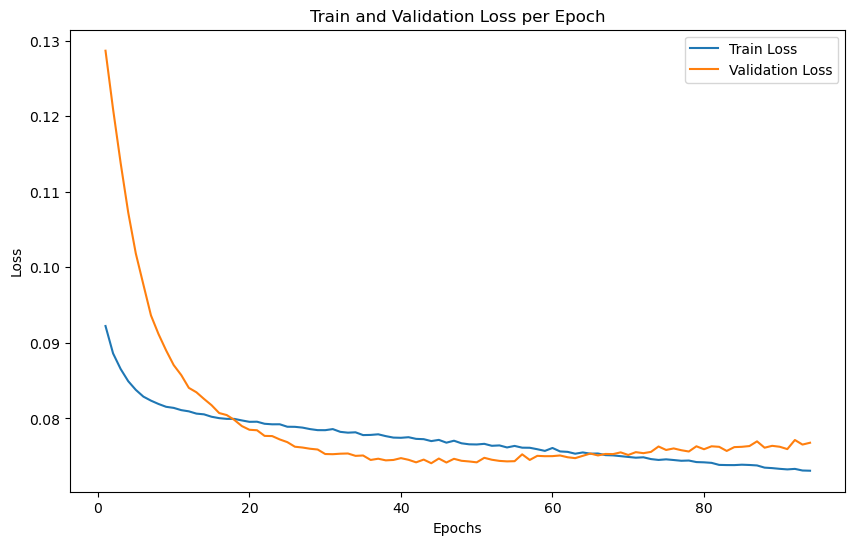

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# 손실 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(train_loss_history) + 1), y=train_loss_history, label="Train Loss")
sns.lineplot(x=range(1, len(val_loss_history) + 1), y=val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss per Epoch")
plt.legend()
plt.show()

In [25]:
def train_and_find_best_model(train_X_seq, train_y_cat, train_ret_seq,
                             val_X_seq, val_y_cat, val_ret_seq,
                             feature_cols, num_classes, lookback,
                             batch_size, learning_rate, unit, Dense_depth, epochs, use_gru=True, patience=50,
                             optimizer=optimizer):
    """
    기능:
    주어진 파라미터를 기반으로 GRU/LSTM 모델을 정의하고, train/val 데이터를 이용해 학습한 뒤
    val_loss 기준으로 최적 모델을 찾는다. (출력, 저장 없음)
    최적 모델 가중치는 함수 내에서 기억해뒀다가 반환.

    입력변수:
    - (생략, 이전과 동일)
    출력변수:
    - best_val_loss: float, 검증 손실 최솟값
    - best_weights: 최적 상태에서의 모델 가중치 (list)
    """
    @tf.function
    def train_step_iter(model, optimizer, x, y, r):
        with tf.GradientTape() as tape:
            y_pred = model(x, training=True)
            loss_value = custom_loss_fn(y, y_pred, r)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss_value

    @tf.function
    def val_step_iter(model, x, y, r):
        y_pred = model(x, training=False)
        loss_value = custom_loss_fn(y, y_pred, r)
        return loss_value, y_pred
        
    model = Sequential()
    if use_gru:
        model.add(GRU(units=unit, activation='elu', input_shape=(lookback, len(feature_cols))))
    else:
        model.add(LSTM(units=unit, activation='elu', input_shape=(lookback, len(feature_cols))))

    for _ in range(Dense_depth):
        model.add(Dense(unit, activation='elu'))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)

    # Dataset 준비
    train_dataset = tf.data.Dataset.from_tensor_slices((train_X_seq, train_y_cat, train_ret_seq)).shuffle(1024).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_X_seq, val_y_cat, val_ret_seq)).batch(batch_size)

    # 더미 인퍼런스
    x_dummy, y_dummy, r_dummy = next(iter(train_dataset))
    model(x_dummy)  # 변수 생성 완료

    best_val_loss = np.inf
    best_weights = None
    early_stopping = EarlyStopping(patience=patience)

    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        train_losses = []
        for x_batch, y_batch, r_batch in train_dataset:
            loss_value = train_step_iter(model, optimizer, x_batch, y_batch, r_batch)
            train_losses.append(loss_value.numpy())

        val_losses = []
        for x_batch, y_batch, r_batch in val_dataset:
            val_loss_value, _ = val_step_iter(model, x_batch, y_batch, r_batch)
            val_losses.append(val_loss_value.numpy())

        val_loss_mean = np.mean(val_losses)
        train_loss_mean = np.mean(train_losses)
        train_loss_history.append(train_loss_mean)
        val_loss_history.append(val_loss_mean)

        if val_loss_mean < best_val_loss:
            best_val_loss = val_loss_mean
            best_weights = model.get_weights()

        early_stopping.check(val_loss_mean)
        if early_stopping.stop_training:
            break

    return best_val_loss, best_weights, model

In [26]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from itertools import product



# Hyperparameter grid 설정
batch_sizes = [64]
learning_rates = [0.0005, 0.00001]
units = [32, 64, 128]
dense_depths = [1, 2]

# 하이퍼파라미터 조합 생성
param_combinations = list(product(batch_sizes, learning_rates, units, dense_depths))

# 최적 파라미터를 저장할 변수
best_val_loss = float('inf')
best_params = None
best_weights = None

# 하이퍼파라미터 조합 순회
for batch_size, learning_rate, unit, dense_depth in tqdm(param_combinations):
    # print(f"Training with batch_size={batch_size}, learning_rate={learning_rate}, unit={unit}, Dense_depth={dense_depth}")
    
    # 모델 학습 및 검증
    val_loss, weights, model = train_and_find_best_model(
        train_X_seq, train_y_cat, train_ret_seq,
        val_X_seq, val_y_cat, val_ret_seq,
        feature_cols, num_classes, lookback,
        batch_size, learning_rate, unit, dense_depth, epochs, use_gru=True, patience=50
    )
    
    # 최적 파라미터 갱신
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = (batch_size, learning_rate, unit, dense_depth)
        best_weights = weights
        model.save('best_model_grid.keras')
        print(f"New best_val_loss: {best_val_loss} with params: {best_params}")

# 최적 파라미터 출력
print(f"Best val_loss: {best_val_loss}")
print(f"Best params: batch_size={best_params[0]}, learning_rate={best_params[1]}, unit={best_params[2]}, Dense_depth={best_params[3]}")

  8%|██████▋                                                                         | 1/12 [11:47<2:09:40, 707.35s/it]

New best_val_loss: 0.11355491727590561 with params: (64, 0.0005, 32, 1)


 25%|████████████████████                                                            | 3/12 [42:16<2:08:55, 859.48s/it]

New best_val_loss: 0.11169973015785217 with params: (64, 0.0005, 64, 1)


 33%|██████████████████████████▋                                                     | 4/12 [56:14<1:53:29, 851.19s/it]

New best_val_loss: 0.10497745871543884 with params: (64, 0.0005, 64, 2)


 42%|████████████████████████████████                                             | 5/12 [1:48:19<3:14:56, 1670.86s/it]

New best_val_loss: 0.1048923060297966 with params: (64, 0.0005, 128, 1)


 50%|██████████████████████████████████████▌                                      | 6/12 [2:41:31<3:38:50, 2188.35s/it]

New best_val_loss: 0.10459543019533157 with params: (64, 0.0005, 128, 2)


100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [6:02:41<00:00, 1813.46s/it]

Best val_loss: 0.10459543019533157
Best params: batch_size=64, learning_rate=0.0005, unit=128, Dense_depth=2


In [ ]:
best_val_loss

# 딥러닝(평가 및 시각화)

In [ ]:
# 모델 로드
final_model = tf.keras.models.load_model('best_model_grid.keras', compile=False)

# 여기서 optimizer를 새로 생성하고 compile을 호출. 
# 하지만 custom_loss_fn은 tf.function 기반으로 train_step/val_step에서만 사용.
# 테스트 시 실제 train_step/val_step는 필요없으나 요청사항에 따라 재정의한 상태 유지.
optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
# 테스트에서는 굳이 compile할 필요가 없지만, 요청사항에 따라 compile 시도를 한다면
# final_model.compile(optimizer=optimizer, loss='categorical_crossentropy')

# 테스트 데이터 예측
y_pred = final_model.predict(test_X_seq, verbose=0)  # (samples, num_classes)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_y_cat, axis=1)

# 정확도 계산
accuracy = np.mean(y_pred_labels == y_true_labels)
print("Test Accuracy:", accuracy)
# 각 Label별 정확도 계산
unique_labels = np.unique(y_true_labels)  # 고유한 클래스 레이블 확인
label_accuracies = {}

for label in unique_labels:
    # 해당 레이블에 대한 마스크 생성
    mask = (y_true_labels == label)
    # 해당 레이블에서의 정확도 계산
    label_accuracy = np.mean(y_pred_labels[mask] == y_true_labels[mask])
    label_accuracies[label] = label_accuracy
    print(f"Accuracy for label {label}: {label_accuracy:.4f}")

# 결과 출력
print("Label-wise Accuracy:", label_accuracies)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import plotly.graph_objects as go

# PNL 계산: combined_df에서 test기간 데이터 추출
test_period_df = combined_df.loc[test_start_date:test_end_date]

# 전략별 일별 수익률: strategy_return_cols
# test_period_df[strategy_return_cols] --> 각 전략별 일일 수익률

# 동일비중 PNL
equal_ret = test_period_df[strategy_return_cols].mean(axis=1).values
def cumulative_pnl(returns):
    return np.cumprod(1 + returns)

# 여기서 lookback을 고려하므로, lookback 이후 구간의 수익률만 사용
subset_equal_ret = equal_ret
pnl_equal = cumulative_pnl(subset_equal_ret)

# 모델 기반 가중평균 PNL
# y_pred는 test_X_seq에 대응하는 샘플들 (lookback 제외한 이후 시점)
# test_period_df의 인덱스 길이와 test_X_seq 길이가 동일해야 함.
# test_X_seq에 대응하는 기간: test_period_df.index[lookback:] 를 사용해야 함
test_dates = test_period_df.index
aligned_returns = test_period_df.loc[test_dates, strategy_return_cols].values  # (samples, num_classes)
model_weighted_ret = np.sum(y_pred * aligned_returns, axis=1)
pnl_model = cumulative_pnl(model_weighted_ret)

# 각 전략별 PNL
pnl_strategy = []
for i in range(num_classes):
    strat_ret = aligned_returns[:, i]
    pnl_strategy.append(cumulative_pnl(strat_ret))

# 시계열 인덱스
# test_dates 는 test_period_df.index[lookback:]
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_dates, y=pnl_model, mode='lines', name='Model Weighted PNL'))
fig.add_trace(go.Scatter(x=test_dates, y=pnl_equal, mode='lines', name='Equal Weight PNL'))
for i in range(num_classes):
    fig.add_trace(go.Scatter(x=test_dates, y=pnl_strategy[i], mode='lines', name=f'Strategy {i+1} PNL'))

fig.update_layout(
    title='Test Period PNL Comparison',
    xaxis_title='Date',
    yaxis_title='PNL (Cumulative Product)',
    legend_title='Strategy'
)

fig.show()